In [1321]:
import re
import string
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.decomposition import PCA, NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.metrics import pairwise_distances

from tabulate import tabulate
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

In [1323]:
df = pd.read_csv('data/tmdb_data.csv',lineterminator='\n')

In [1324]:
df.head()

,id,title,overview,original_language,budget,revenue,release_date,vote_average,vote_count,director,lead_actor_1,lead_actor_2,lead_actor_3,lead_actor_4
0,2.0,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,fi,0.0,0.0,1988-10-21,6.9,150.0,Aki Kaurismäki,Turo Pajala,Susanna Haavisto,Matti Pellonpää,Eetu Hilkamo
1,3.0,Shadows in Paradise,"An episode in the life of Nikander, a garbage ...",fi,0.0,0.0,1986-10-17,7.2,149.0,Aki Kaurismäki,Matti Pellonpää,Kati Outinen,Sakari Kuosmanen,Esko Nikkari
2,5.0,Four Rooms,It's Ted the Bellhop's first night on the job....,en,4000000.0,4257354.0,1995-12-09,5.7,2037.0,Allison Anders,Tim Roth,Jennifer Beals,Antonio Banderas,Valeria Golino
3,6.0,Judgment Night,"While racing to a boxing match, Frank, Mike, J...",en,21000000.0,12136938.0,1993-10-15,6.5,215.0,Stephen Hopkins,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,Stephen Dorff
4,11.0,Star Wars,Princess Leia is captured and held hostage by ...,en,11000000.0,775398007.0,1977-05-25,8.2,16282.0,George Lucas,Mark Hamill,Harrison Ford,Carrie Fisher,Peter Cushing


**Initial data cleaning**

In [1325]:
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'],inplace=True)
df.sort_values('vote_count',ascending=False).head()

,id,title,overview,original_language,budget,revenue,release_date,vote_average,vote_count,director,lead_actor_1,lead_actor_2,lead_actor_3,lead_actor_4
9244,27205.0,Inception,"Cobb, a skilled thief who commits corporate es...",en,160000000.0,8.255328e+08,2010-07-15,8.3,30268.0,Christopher Nolan,Leonardo DiCaprio,Joseph Gordon-Levitt,Ken Watanabe,Tom Hardy
17023,157336.0,Interstellar,The adventures of a group of explorers who mak...,en,165000000.0,7.017292e+08,2014-11-05,8.4,27085.0,Christopher Nolan,Matthew McConaughey,Anne Hathaway,Jessica Chastain,Ellen Burstyn
106,155.0,The Dark Knight,Batman raises the stakes in his war on crime. ...,en,185000000.0,1.004558e+09,2008-07-14,8.5,26226.0,Christopher Nolan,Christian Bale,Heath Ledger,Michael Caine,Gary Oldman
19541,293660.0,Deadpool,Deadpool tells the origin story of former Spec...,en,58000000.0,7.831000e+08,2016-02-09,7.6,25795.0,Tim Miller,Ryan Reynolds,Morena Baccarin,Ed Skrein,T. J. Miller
8539,24428.0,The Avengers,When an unexpected enemy emerges and threatens...,en,220000000.0,1.518816e+09,2012-04-25,7.7,25727.0,Joss Whedon,Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth


In [1326]:
df.describe()

,id,budget,revenue,vote_average,vote_count
count,30853.000000,3.085300e+04,3.085300e+04,30853.000000,30853.000000
mean,233910.442712,7.488630e+06,2.040349e+07,6.109279,502.652838
std,255770.333160,2.307611e+07,8.899861e+07,1.516460,1546.045331
min,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,20453.000000,0.000000e+00,0.000000e+00,5.600000,36.000000
50%,83651.000000,0.000000e+00,0.000000e+00,6.400000,89.000000
75%,428584.000000,2.159280e+06,1.234254e+06,7.000000,275.000000
max,899196.000000,3.800000e+08,2.847246e+09,10.000000,30268.000000


In [1327]:
#Combine Actor/director names into one string. This makes for easier preprocessing
#For example, Chris Evans and Chris Hemsworth are treated as separate actors instead of 50% similar
#Also include feature engineering

df['lead_actor_1'] = df['lead_actor_1'].str.replace(' ', '')
df['lead_actor_2'] = df['lead_actor_2'].str.replace(' ', '')
df['lead_actor_3'] = df['lead_actor_3'].str.replace(' ', '')
df['lead_actor_4'] = df['lead_actor_4'].str.replace(' ', '')
df['director'] = df['director'].str.replace(' ', '')
df.head(1)

,id,title,overview,original_language,budget,revenue,release_date,vote_average,vote_count,director,lead_actor_1,lead_actor_2,lead_actor_3,lead_actor_4
0,2.0,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,fi,0.0,0.0,1988-10-21,6.9,150.0,AkiKaurismäki,TuroPajala,SusannaHaavisto,MattiPellonpää,EetuHilkamo


In [1328]:
#Want to replace "New York City" and "New York" with "NYC"
#Replace World War II with single word


df['overview'] = df['overview'].str.replace('New York City', 'NYC', regex=False)
df['overview'] = df['overview'].str.replace('New York', 'NYC', regex=False)
df['overview'] = df['overview'].str.replace('World War II', 'worldwarii', regex=False)
df['overview'] = df['overview'].str.replace('World War 2', 'worldwarii', regex=False)
df['overview'] = df['overview'].str.replace('WWII', 'worldwarii', regex=False)

Combine lead actors, directors, and plot overview into one singular bag of words

In [1329]:
cols = ['overview', 'lead_actor_1', 'lead_actor_2','lead_actor_3','lead_actor_4','director']
df['bag_of_words'] = df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df.loc[19710]['bag_of_words']

'As the Avengers and their allies have continued to protect the world from threats too large for any one hero to handle, a new danger has emerged from the cosmic shadows: Thanos. A despot of intergalactic infamy, his goal is to collect all six Infinity Stones, artifacts of unimaginable power, and use them to inflict his twisted will on all of reality. Everything the Avengers have fought for has led up to this moment - the fate of Earth and existence itself has never been more uncertain. RobertDowneyJr. ChrisHemsworth MarkRuffalo ChrisEvans AnthonyRusso'

In [1330]:
#Filter movies that are in English and of a certain popularity. This is for simplicity
df2 = df[(df['original_language'] == 'en') & (df['vote_count'] > 1000)]
df2.reset_index(inplace=True)
df2.head()

,index,id,title,overview,original_language,budget,revenue,release_date,vote_average,vote_count,director,lead_actor_1,lead_actor_2,lead_actor_3,lead_actor_4,bag_of_words
0,2,5.0,Four Rooms,It's Ted the Bellhop's first night on the job....,en,4000000.0,4257354.0,1995-12-09,5.7,2037.0,AllisonAnders,TimRoth,JenniferBeals,AntonioBanderas,ValeriaGolino,It's Ted the Bellhop's first night on the job....
1,4,11.0,Star Wars,Princess Leia is captured and held hostage by ...,en,11000000.0,775398007.0,1977-05-25,8.2,16282.0,GeorgeLucas,MarkHamill,HarrisonFord,CarrieFisher,PeterCushing,Princess Leia is captured and held hostage by ...
2,5,12.0,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp...",en,94000000.0,940335536.0,2003-05-30,7.8,15665.0,AndrewStanton,AlbertBrooks,EllenDeGeneres,AlexanderGould,WillemDafoe,"Nemo, an adventurous young clownfish, is unexp..."
3,6,13.0,Forrest Gump,A man with a low IQ has accomplished great thi...,en,55000000.0,677387716.0,1994-07-06,8.5,21605.0,RobertZemeckis,TomHanks,RobinWright,GarySinise,MykeltiWilliamson,A man with a low IQ has accomplished great thi...
4,7,14.0,American Beauty,"Lester Burnham, a depressed suburban father in...",en,15000000.0,356296601.0,1999-09-15,8.0,9769.0,SamMendes,KevinSpacey,AnnetteBening,ThoraBirch,WesBentley,"Lester Burnham, a depressed suburban father in..."


In [1331]:
sum([len(d.split(' ')) for d in df2['bag_of_words']])

155019

**More Feature Engineering**

There are other movie features that will help boost the similarity scores of like-films. The following variables will be added (as a text term to add to bag of words):

- bigbudget: If a movie has an inflation adjusted budget of over $220,000,000 (based on an inflation rate of [3.1%](https://inflationdata.com/Inflation/Inflation/DecadeInflation.asp#/)), it gets flagged
- popularmovie: If a movie has over 11000 votes, it gets flagged as a popular movie. This metric is used rather than gross because in today's age, numerous movies are straight to streaming, thus having no box office data
- highlyrated: If a movie has a rating of over 8.0, it gets flagged as a highly rated movie.
- Oldfilm: Movies released prior to 1950 will be flagged as "oldfilm". There will be some users that have a particular affinity for the classics so having some type of indicator could potentially add value.

The thresholds seem arbitrary but they are nice, round numbers that are near the 95th percentile of each data point. The exception being films released prior to 1950, which was the 1st percentile of data.

In [1332]:
df2.describe()

,index,id,budget,revenue,vote_average,vote_count
count,2960.000000,2960.000000,2.960000e+03,2.960000e+03,2960.000000,2960.000000
mean,10179.168581,126018.935473,4.866624e+07,1.684035e+08,6.750980,3670.899662
std,8865.109293,172452.325217,5.241109e+07,2.332518e+08,0.754985,3588.426908
min,2.000000,5.000000,0.000000e+00,0.000000e+00,2.900000,1001.000000
25%,1892.500000,4976.000000,1.100000e+07,3.199331e+07,6.200000,1416.750000
50%,7136.000000,18483.500000,3.000000e+07,9.330149e+07,6.700000,2321.500000
75%,18379.000000,244314.750000,6.900000e+07,2.076231e+08,7.300000,4439.000000
max,29692.000000,791373.000000,3.800000e+08,2.847246e+09,8.700000,30268.000000


In [1333]:
df2['release_date'] = pd.to_datetime(df2['release_date'])
df2['year'] = pd.DatetimeIndex(df2['release_date']).year

df2['budget_2021'] = df2['budget'] * 1.031 ** (2021 - df2['year'])
df2.loc[df2['budget_2021'] >= 22000000, 'bigbudget'] = 'bigbudget'
df2.loc[df2['budget_2021'] < 220000000, 'bigbudget'] = ''

df2.loc[df2['vote_count'] >= 11000, 'popularmovie'] = 'popularmovie'
df2.loc[df2['vote_count'] < 11000, 'popularmovie'] = ''

df2.loc[df2['vote_average'] >= 8, 'highlyrated'] = 'highlyrated'
df2.loc[df2['vote_average'] < 8, 'highlyrated'] = ''

df2['decade'] = df2['year'] - (df2['year']%10)
df2.loc[df2['year'] < 1950 , 'oldfilm'] = 'oldfilm'
df2.loc[df2['year'] >= 1950 , 'oldfilm'] = ''

df2.head()

/var/folders/75/fwf63z_j1jvf891tg0n68jn80000gn/T/ipykernel_11073/4138847789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['release_date'] = pd.to_datetime(df2['release_date'])
/var/folders/75/fwf63z_j1jvf891tg0n68jn80000gn/T/ipykernel_11073/4138847789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['year'] = pd.DatetimeIndex(df2['release_date']).year
/var/folders/75/fwf63z_j1jvf891tg0n68jn80000gn/T/ipykernel_11073/4138847789.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

,index,id,title,overview,original_language,budget,revenue,release_date,vote_average,vote_count,...,lead_actor_3,lead_actor_4,bag_of_words,year,budget_2021,bigbudget,popularmovie,highlyrated,decade,oldfilm
0,2,5.0,Four Rooms,It's Ted the Bellhop's first night on the job....,en,4000000.0,4257354.0,1995-12-09,5.7,2037.0,...,AntonioBanderas,ValeriaGolino,It's Ted the Bellhop's first night on the job....,1995,8.846781e+06,,,,1990,
1,4,11.0,Star Wars,Princess Leia is captured and held hostage by ...,en,11000000.0,775398007.0,1977-05-25,8.2,16282.0,...,CarrieFisher,PeterCushing,Princess Leia is captured and held hostage by ...,1977,4.214771e+07,,popularmovie,highlyrated,1970,
2,5,12.0,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp...",en,94000000.0,940335536.0,2003-05-30,7.8,15665.0,...,AlexanderGould,WillemDafoe,"Nemo, an adventurous young clownfish, is unexp...",2003,1.628485e+08,,popularmovie,,2000,
3,6,13.0,Forrest Gump,A man with a low IQ has accomplished great thi...,en,55000000.0,677387716.0,1994-07-06,8.5,21605.0,...,GarySinise,MykeltiWilliamson,A man with a low IQ has accomplished great thi...,1994,1.254142e+08,,popularmovie,highlyrated,1990,
4,7,14.0,American Beauty,"Lester Burnham, a depressed suburban father in...",en,15000000.0,356296601.0,1999-09-15,8.0,9769.0,...,ThoraBirch,WesBentley,"Lester Burnham, a depressed suburban father in...",1999,2.936175e+07,,,highlyrated,1990,


In [1334]:
df2['year'].quantile(0.01)

1952.59

In [1335]:
cols = ['bag_of_words', 'bigbudget', 'popularmovie','highlyrated','oldfilm']
df2['bag_of_words2'] = df2[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df2.loc[2369]['bag_of_words2']

/var/folders/75/fwf63z_j1jvf891tg0n68jn80000gn/T/ipykernel_11073/2404427785.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['bag_of_words2'] = df2[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)


'As the Avengers and their allies have continued to protect the world from threats too large for any one hero to handle, a new danger has emerged from the cosmic shadows: Thanos. A despot of intergalactic infamy, his goal is to collect all six Infinity Stones, artifacts of unimaginable power, and use them to inflict his twisted will on all of reality. Everything the Avengers have fought for has led up to this moment - the fate of Earth and existence itself has never been more uncertain. RobertDowneyJr. ChrisHemsworth MarkRuffalo ChrisEvans AnthonyRusso bigbudget popularmovie highlyrated '

In [1336]:
df_short = df2[['title','bag_of_words2']]
df_short

,title,bag_of_words2
0,Four Rooms,It's Ted the Bellhop's first night on the job....
1,Star Wars,Princess Leia is captured and held hostage by ...
2,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp..."
3,Forrest Gump,A man with a low IQ has accomplished great thi...
4,American Beauty,"Lester Burnham, a depressed suburban father in..."
...,...,...
2955,Gabriel's Inferno Part II,Professor Gabriel Emerson finally learns the t...
2956,The Kissing Booth 3,"It’s the summer before Elle heads to college, ..."
2957,Borat Subsequent Moviefilm,14 years after making a film about his journey...
2958,Outside the Wire,"In the near future, a drone pilot is sent into..."


**Preprocessing Data**
- Stop words (like, is, the, etc) are removed
- Text is cleaned (remove punctuation, all lower case, amongst others), to ensure apples-to-apples comparisons
- Lemmatization is performed (combine like words such as run and running)

In [1337]:
def cleantext(df):
    whitespace_token = RegexpTokenizer("\s+|[\.?!-]|[\u2026]", gaps=True) #split on white space, (.?!), and (...)
    df['token_doc'] = df['bag_of_words2'].apply(whitespace_token.tokenize)
    stop_words = list(ENGLISH_STOP_WORDS)
    df['clean_doc'] = df['token_doc'].apply(lambda x: [word for word in x if word.lower() not in stop_words])
    
    def clean_data(data):
        lst = []
        for word in data:

            word = word.lower()
            word = re.sub(r'''[!()[\]{};?@#$%:\'\"\,.^&*_`]''','',word) #remove all punctuation 
            word = re.sub(r'\w*\d\w*','',word) #remove all number and words containing numbers
            word = re.sub(u'[\u201C]|[\u201D]','',word) #remove special "" with unicode
            word = re.sub(r'(^| ).( |$)','',word) #remove any character that is one unit in length

            lst.append(word)
        return lst

    def remove_white_space(data):
        while '' in data:
            data.remove('')
        return data

    df['clean_doc'] = df['clean_doc'].apply(clean_data)
    df['clean_doc'] = df['clean_doc'].apply(remove_white_space)
    
    #Lemmatize words to group like words (such as run and running)
    wordnet_lemmatizer = WordNetLemmatizer()
    df['clean_doc'] = df['clean_doc'].apply(lambda x: [wordnet_lemmatizer.lemmatize(word) for word in x])
    
    df_clean = df['clean_doc']
    
    df_clean = df_clean.apply(lambda x: ' '.join(map(str,x)))
    
    return df_clean

In [1338]:
df_clean = cleantext(df_short)

/var/folders/75/fwf63z_j1jvf891tg0n68jn80000gn/T/ipykernel_11073/3618156397.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['token_doc'] = df['bag_of_words2'].apply(whitespace_token.tokenize)
/var/folders/75/fwf63z_j1jvf891tg0n68jn80000gn/T/ipykernel_11073/3618156397.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_doc'] = df['token_doc'].apply(lambda x: [word for word in x if word.lower() not in stop_words])
/var/folders/75/fwf63z_j1jvf891tg0n68jn80000gn/T/ipykernel_11073/3618156397.py:

In [1339]:
df_clean[2369]

'avenger ally continued protect world threat large hero handle new danger emerged cosmic shadow thanos despot intergalactic infamy goal collect infinity stone artifact unimaginable power use inflict twisted reality avenger fought led moment fate earth existence uncertain robertdowneyjr chrishemsworth markruffalo chrisevans anthonyrusso bigbudget popularmovie highlyrated'

In [1340]:
df2.loc[2369]['bag_of_words2']

'As the Avengers and their allies have continued to protect the world from threats too large for any one hero to handle, a new danger has emerged from the cosmic shadows: Thanos. A despot of intergalactic infamy, his goal is to collect all six Infinity Stones, artifacts of unimaginable power, and use them to inflict his twisted will on all of reality. Everything the Avengers have fought for has led up to this moment - the fate of Earth and existence itself has never been more uncertain. RobertDowneyJr. ChrisHemsworth MarkRuffalo ChrisEvans AnthonyRusso bigbudget popularmovie highlyrated '

In [1341]:
df_short.head()

,title,bag_of_words2,token_doc,clean_doc
0,Four Rooms,It's Ted the Bellhop's first night on the job....,"[It's, Ted, the, Bellhop's, first, night, on, ...","[it, ted, bellhop, night, job, hotel, unusual,..."
1,Star Wars,Princess Leia is captured and held hostage by ...,"[Princess, Leia, is, captured, and, held, host...","[princess, leia, captured, held, hostage, evil..."
2,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp...","[Nemo,, an, adventurous, young, clownfish,, is...","[nemo, adventurous, young, clownfish, unexpect..."
3,Forrest Gump,A man with a low IQ has accomplished great thi...,"[A, man, with, a, low, IQ, has, accomplished, ...","[man, low, iq, accomplished, great, thing, lif..."
4,American Beauty,"Lester Burnham, a depressed suburban father in...","[Lester, Burnham,, a, depressed, suburban, fat...","[lester, burnham, depressed, suburban, father,..."


**Build initial Doc Term Matrix**

In [835]:
cv = CountVectorizer(max_df=.7)

doc_word_matrix_cv = cv.fit_transform(df_clean)
doc_term_cv = pd.DataFrame(doc_word_matrix_cv.toarray(), index = df_short['title'],columns=cv.get_feature_names())
vocab_cv = cv.get_feature_names()

In [1342]:
#Ultimately, TFIDF is being used
tfidf = TfidfVectorizer(max_df=.7)

doc_word_matrix_tf = tfidf.fit_transform(df_clean)
doc_term = pd.DataFrame(doc_word_matrix_tf.toarray(), index = df_short['title'],columns=tfidf.get_feature_names())
vocab = tfidf.get_feature_names()

In [1343]:
doc_term.head()

,aames,aang,aaranthomas,aaron,aaronblaise,aaronburns,aaroneckhart,aaronhann,aaronpaul,aaronruell,...,zorin,zorro,zoëbell,zoëkravitz,zula,zune,æon,émigré,ólafurdarriólafsson,óscarjaenada
title,,,,,,,,,,,,,,,,,,,,,
Four Rooms,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Star Wars,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Finding Nemo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Forrest Gump,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
American Beauty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1344]:
doc_term['worldwarii'].sort_values(ascending=False)

title
Enemy at the Gates              0.216692
Unbroken                        0.212004
Schindler's List                0.196124
The Way Back                    0.195955
Letters from Iwo Jima           0.193153
                                  ...   
In the Line of Fire             0.000000
Conan the Barbarian             0.000000
Thank You for Smoking           0.000000
Jerry Maguire                   0.000000
Zack Snyder's Justice League    0.000000
Name: worldwarii, Length: 2960, dtype: float64

In [1345]:
doc_term.shape

(2960, 18801)

In [1346]:
doc_term.iloc[2369][doc_term.iloc[2369] > 0][:10]

ally              0.131123
anthonyrusso      0.167844
artifact          0.172093
avenger           0.316788
bigbudget         0.092209
chrisevans        0.139783
chrishemsworth    0.142239
collect           0.153717
continued         0.183999
cosmic            0.172093
Name: Avengers: Infinity War, dtype: float64

**NMF (nonNegative Matrix Factorization) Dimensionality Reduction**

18 Topics is optimal, the following code calculates the coherence score for a wide range of topics

In [1347]:
#Get optimal number of topics
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.nmf import Nmf
import operator

texts = df_short['clean_doc']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 25 + 1, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

#nmf = NMF(n_components=10, init=None,alpha=0)

for num in topic_nums:
    nmf_test = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf_test,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=operator.itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

18


In [1348]:
sorted(scores, key=operator.itemgetter(1), reverse=True)

[(18, 0.3047),
 (11, 0.30369),
 (13, 0.29965),
 (14, 0.29597),
 (12, 0.29072),
 (23, 0.29037),
 (17, 0.28958),
 (15, 0.28881),
 (9, 0.28751),
 (22, 0.2861),
 (25, 0.28578),
 (6, 0.28552),
 (24, 0.28415),
 (7, 0.28163),
 (10, 0.2774),
 (16, 0.27401),
 (20, 0.27386),
 (19, 0.27284),
 (8, 0.26693),
 (21, 0.26475),
 (5, 0.25635)]

In [1349]:
nmf_terms=18
nmf = NMF(n_components=nmf_terms, init=None,alpha=0)

doc_topic_nmf = nmf.fit_transform(doc_term)

In [1350]:
doc_topic_nmf.shape

(2960, 18)

In [1351]:
doc_topic_nmf_df = pd.DataFrame(doc_topic_nmf, index = df_short['title']).add_prefix('Topic_')
doc_topic_nmf_df.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17
title,,,,,,,,,,,,,,,,,,
Four Rooms,0.003989,0.0,0.004607,0.005228,0.000000,0.006645,0.000711,0.000000,0.000000,0.002114,0.000000,0.004812,0.009232,0.002026,0.009347,0.006351,0.039861,0.003394
Star Wars,0.000000,0.0,0.009080,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.194856,0.000000,0.000000,0.000000,0.000000,0.007233,0.000000,0.000000
Finding Nemo,0.000196,0.0,0.000000,0.000000,0.018348,0.001162,0.000000,0.055369,0.000000,0.000000,0.037244,0.004129,0.006540,0.000000,0.002187,0.000000,0.006021,0.000000
Forrest Gump,0.028073,0.0,0.000000,0.000000,0.000000,0.000000,0.044122,0.000000,0.030164,0.000000,0.041892,0.000000,0.000000,0.000000,0.000000,0.083911,0.000000,0.000000
American Beauty,0.000000,0.0,0.000000,0.000000,0.002577,0.014572,0.119799,0.011258,0.000000,0.008376,0.001268,0.000000,0.000000,0.000000,0.052122,0.000000,0.000000,0.000000


In [1442]:
n_terms = 15     # Select the top 15 words in vocab for each topic.
for idx, topic in enumerate(nmf.components_):
    top_words = [vocab[i].upper() for i in topic.argsort()[:-n_terms-1:-1]]
    print(f"Topic {idx}:\n", ", ".join(top_words), "\n")

Topic 0:
 MAN, WIFE, PETER, SAMUELL, JACKSON, SPIDER, HIGHLYRATED, ALTER, CRIMINAL, TRY, MAKE, DRUG, SET, DEATH, BODY 

Topic 1:
 EARTH, ALIEN, PLANET, HUMAN, CREW, RACE, SAVE, SPACE, MISSION, FORCE, FUTURE, SCIENTIST, FIGHT, POWERFUL, HUMANITY 

Topic 2:
 AGENT, TEAM, FBI, POLICE, BOND, COP, DRUG, CIA, SECRET, KILLER, GOVERNMENT, MISSION, JAMES, MURDER, DETECTIVE 

Topic 3:
 SCHOOL, HIGH, STUDENT, GIRL, TEACHER, COLLEGE, POPULAR, SENIOR, CRUSH, CLASS, GRADUATION, JOCK, PRINCIPAL, MIDDLE, POWER 

Topic 4:
 FAMILY, HOME, CHILD, BROTHER, HOUSE, EVENT, SON, RETURN, KILLER, PARENT, DAUGHTER, WIFE, SPIRIT, LITTLE, FORCED 

Topic 5:
 YEAR, OLD, LATER, FATHER, BOY, GIRL, DAUGHTER, RETURN, SON, SECRET, MOTHER, REUNITES, OLDER, MEET, HOUSE 

Topic 6:
 LIFE, DEATH, CHANGE, JUST, CAREER, MAKE, DOG, COME, UPSIDE, SINGLE, JACK, RISK, BENSTILLER, HIGHLYRATED, MEANING 

Topic 7:
 YOUNG, WOMAN, FATHER, HELP, BOY, MYSTERIOUS, MOTHER, SON, DISCOVERS, FIND, HUSBAND, MEET, HOME, CHILD, SEARCH 

Topic 8:
 

In [1444]:
doc_topic_nmf_df.columns

Index(['Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5',
       'Topic_6', 'Topic_7', 'Topic_8', 'Topic_9', 'Topic_10', 'Topic_11',
       'Topic_12', 'Topic_13', 'Topic_14', 'Topic_15', 'Topic_16', 'Topic_17'],
      dtype='object')

In [1448]:
#Rename Columns for easy analysis
col_rename = {'Topic_0':'Action', 'Topic_1':'Sci-Fi', 'Topic_2':'Spy-Fiction', 'Topic_3':'High School Comedies', 
              'Topic_4':'Thriller/Suspense', 'Topic_5':'Drama','Topic_6':'Dramedies', 'Topic_7':'Mystery', 
              'Topic_8':'Award Winning War Drama', 'Topic_9':'Zombies', 'Topic_10':'Big Budget Action Franchise', 
              'Topic_11': 'Miscellaneous', 'Topic_12':'Competitive Action', 'Topic_13':'Adventure', 
              'Topic_14':'Comedy', 'Topic_15': 'Romance', 'Topic_16':'Romantic Comedy', 'Topic_17':'Vampires'}

doc_topic_nmf_df_describe = doc_topic_nmf_df.rename(columns=col_rename)
doc_topic_nmf_df_describe

,Action,Sci-Fi,Spy-Fiction,High School Comedies,Thriller/Suspense,Drama,Dramedies,Mystery,Award Winning War Drama,Zombies,Big Budget Action Franchise,Miscellaneous,Competitive Action,Adventure,Comedy,Romance,Romantic Comedy,Vampires
title,,,,,,,,,,,,,,,,,,
Four Rooms,0.003989,0.000000,0.004607,0.005228,0.000000,0.006645,0.000711,0.000000,0.000000,0.002114,0.000000,0.004812,0.009232,0.002026,0.009347,0.006351,0.039861,0.003394
Star Wars,0.000000,0.000000,0.009080,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.194856,0.000000,0.000000,0.000000,0.000000,0.007233,0.000000,0.000000
Finding Nemo,0.000196,0.000000,0.000000,0.000000,0.018348,0.001162,0.000000,0.055369,0.000000,0.000000,0.037244,0.004129,0.006540,0.000000,0.002187,0.000000,0.006021,0.000000
Forrest Gump,0.028073,0.000000,0.000000,0.000000,0.000000,0.000000,0.044122,0.000000,0.030164,0.000000,0.041892,0.000000,0.000000,0.000000,0.000000,0.083911,0.000000,0.000000
American Beauty,0.000000,0.000000,0.000000,0.000000,0.002577,0.014572,0.119799,0.011258,0.000000,0.008376,0.001268,0.000000,0.000000,0.000000,0.052122,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gabriel's Inferno Part II,0.001392,0.000000,0.000244,0.000000,0.000000,0.002222,0.006815,0.000009,0.007622,0.000000,0.010394,0.003217,0.000000,0.001956,0.002974,0.103580,0.001644,0.000000
The Kissing Booth 3,0.000000,0.000000,0.011033,0.020849,0.001999,0.002436,0.003744,0.001467,0.000000,0.000000,0.000000,0.005381,0.002255,0.000820,0.051284,0.003582,0.003013,0.003755
Borat Subsequent Moviefilm,0.000000,0.000000,0.000041,0.000000,0.000000,0.054479,0.057692,0.058646,0.013490,0.002284,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [1449]:
doc_topic_nmf_df_describe.idxmax()

Action                                                Papillon
Sci-Fi                                               Meet Dave
Spy-Fiction                                      Atomic Blonde
High School Comedies                            21 Jump Street
Thriller/Suspense                                   Dark Skies
Drama                            Jackass Presents: Bad Grandpa
Dramedies                      The Secret Life of Walter Mitty
Mystery                                  Promising Young Woman
Award Winning War Drama                    Hachi: A Dog's Tale
Zombies                                     The Dead Don't Die
Big Budget Action Franchise           Star Wars: The Last Jedi
Miscellaneous                                Coming to America
Competitive Action                              Wreck-It Ralph
Adventure                                    Girl, Interrupted
Comedy                                     No Strings Attached
Romance                                             Ann

In [1450]:
doc_topic_nmf_df.sort_values('Topic_1',ascending=False).head(20)

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17
title,,,,,,,,,,,,,,,,,,
Meet Dave,0.000000,0.213089,0.000000,0.000000,0.000000,0.000000,0.000000,0.016080,0.000000,0.000000,0.000000,0.061696,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Pacific Rim,0.000000,0.195534,0.000000,0.000000,0.000000,0.023555,0.000000,0.000000,0.000000,0.000000,0.026154,0.000000,0.001824,0.000000,0.000000,0.000000,0.000000,0.000000
Prometheus,0.000000,0.180771,0.000000,0.000571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004434,0.000000,0.000000,0.009943,0.000000,0.000000,0.001207,0.001858
Alien,0.000000,0.164179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004732,0.000000,0.009121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
District 9,0.000973,0.162622,0.008096,0.000000,0.000000,0.023525,0.000000,0.000000,0.000000,0.001863,0.000000,0.000000,0.001327,0.000000,0.000000,0.000000,0.000000,0.000000
Star Trek IV: The Voyage Home,0.000000,0.156001,0.000000,0.000000,0.000000,0.000000,0.000430,0.000000,0.000500,0.000000,0.000000,0.000000,0.000000,0.035684,0.004384,0.000000,0.011238,0.000000
The Day the Earth Stood Still,0.000000,0.153626,0.000000,0.000000,0.000000,0.000000,0.002498,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Godzilla vs. Kong,0.000000,0.150547,0.000000,0.000000,0.000000,0.000000,0.000683,0.000000,0.006963,0.000000,0.016056,0.000000,0.000000,0.000000,0.000000,0.000000,0.003986,0.000000
Riddick,0.000000,0.140946,0.000000,0.000000,0.014991,0.000000,0.000000,0.000000,0.000000,0.001793,0.000000,0.005297,0.007194,0.000000,0.000000,0.000128,0.000000,0.004796


In [1451]:
doc_topic_nmf_df_describe.max()

Action                         0.079352
Sci-Fi                         0.213089
Spy-Fiction                    0.185396
High School Comedies           0.279947
Thriller/Suspense              0.214890
Drama                          0.224662
Dramedies                      0.195196
Mystery                        0.133459
Award Winning War Drama        0.167338
Zombies                        0.267339
Big Budget Action Franchise    0.216097
Miscellaneous                  0.270273
Competitive Action             0.314081
Adventure                      0.179957
Comedy                         0.283265
Romance                        0.192981
Romantic Comedy                0.279160
Vampires                       0.462457
dtype: float64

**Experiment with PCA**
The data shows a very small explained variance ratio even for a large n components, so this technique is not ideal for this project

In [1105]:
pca = PCA(n_components=1000)

doc_topic_pca = pca.fit_transform(doc_term)
sum(pca.explained_variance_ratio_)

0.582255537523703

In [1106]:
doc_topic_pca_df = pd.DataFrame(doc_topic_pca, index = df_short['title']).add_prefix('Topic_')
doc_topic_pca_df.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,...,Topic_990,Topic_991,Topic_992,Topic_993,Topic_994,Topic_995,Topic_996,Topic_997,Topic_998,Topic_999
title,,,,,,,,,,,,,,,,,,,,,
Four Rooms,-0.018750,-0.040880,0.008529,0.004336,-0.004459,-0.009038,-0.015925,-0.063351,0.003273,0.000276,...,0.028375,0.022461,-0.010923,0.007859,0.001781,-0.039853,-0.011613,-0.002875,-0.026158,0.014981
Star Wars,0.100246,0.026780,0.027579,-0.033748,-0.047735,0.041435,-0.063563,0.000046,0.045443,0.092029,...,-0.000347,0.001056,-0.004941,0.008327,0.012409,-0.001985,0.008778,0.014498,0.001743,0.004656
Finding Nemo,-0.004579,0.032196,-0.027780,0.030553,-0.057947,0.005547,0.027377,-0.016793,0.012651,0.014449,...,0.010302,-0.006919,0.001116,-0.021891,0.012481,0.021302,0.045072,0.000215,0.001224,-0.013900
Forrest Gump,-0.045606,0.060729,-0.033801,-0.132241,0.010763,0.064008,-0.019431,0.013636,0.046372,0.053984,...,0.006327,-0.013815,0.027715,0.006181,0.025861,-0.001104,-0.028004,-0.013810,-0.025460,0.005728
American Beauty,-0.101891,0.030506,-0.034767,-0.041399,0.090900,-0.037078,-0.002267,0.039036,0.043286,0.003703,...,-0.010150,-0.010715,-0.024159,-0.032694,0.011614,-0.013519,-0.000955,-0.001443,0.008635,0.031402


**TFIDF CorEx Topic Modeling**: CorEx resulted in very specific, franchise-oriented topics. NMF is more generalized and is better suited for this project.

In [834]:
topic_anchors = [['highlyrated'],
                 ['popularmovie','bigbudget'],
                 ['comedy'],
                 ['worldwarii'],
                 ['vampire','werewolf']
                ]

corex_model = ct.Corex(n_hidden=20, words=vocab, seed=42,
                 anchors=topic_anchors, 
                 anchor_strength=10
                      )
corex_model.fit(doc_word_matrix_tf, words=vocab)

topics = corex_model.get_topics()

for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('Topic {}:'.format(n+1))
    print(', '.join(topic_words), '\n')

Topic 1:
humbert, shaun, truman, michaelmoore, greek, jims, stifler, bennettmiller, bush, salander 

Topic 2:
aladdin, ianmckellen, bilbo, jonathangroff, kristoff, rogermoore, selene, lycans, idinamenzel, annacathcart 

Topic 3:
rocky, katniss, sylvesterstallone, shrek, decepticons, autobots, creed, johng, avildsen, transformer 

Topic 4:
charliechaplin, tramp, wick, katiefeatherston, henryjoost, earl, terry, oldfilm, dumbledore, voldemorts 

Topic 5:
alfredhitchcock, sidney, mollyringwald, vienna, orsonwelles, celine, ralph, mollie, vincemarcello, jacobelordi 

Topic 6:
plant, fester, ll, foreman, cocktail, lighthouse, lost, caul, nada, freeway 

Topic 7:
jigsaw, smurfs, tobinbell, nemo, billywilder, luthor, costasmandylor, betsyrussell, gal, austin 

Topic 8:
thor, imperial, melody, garfield, lena, mermaid, aidangillen, commits, mulan, markhamill 

Topic 9:
myers, laurie, warren, halloween, sal, lorraine, robocop, haddonfield, jamieleecurtis, scully 

Topic 10:
chuck, troll, chipmunk

**Recommendation System**

I have created single and multiple input recommendation systems. The multiple recommendation system helps mitigate the issue of content based recommendation systems, which is that we are suscepitble to providing obvious solutions as opposed to insightful ones

In [1405]:
##Test out nmf recommendation system
def recommendation_single(x, n_recs=5):
    print('You selected:')
    print(df2['title'][x])
    #print(df['original_summary'][movie_idx][:100] + '...')
    print('\n')
    print('You may also like:')

    recs = pairwise_distances(np.array(doc_topic_nmf[x]).reshape(1,-1), 
                              doc_topic_nmf, metric='cosine').argsort()[0][1:]
        
    for i in range(n_recs):
        print('\t', recs[i], df2['title'][recs[i]])
        #print('\t', df['original_summary'][recs[i]][:100] + '...')
recommendation_single(2369,5)

You selected:
Avengers: Infinity War


You may also like:
	 279 Harry Potter and the Order of the Phoenix
	 2448 Rogue One: A Star Wars Story
	 560 Hulk
	 2046 Star Wars: The Force Awakens
	 370 Toy Story


In [1423]:
def recommendation_pair(x1, x2, n_recs=5):
    print('First selected movie:')
    print(df2['title'][x1])
    print('\n')
    
    print('Second selected movie:')
    print(df2['title'][x2])
    print('\n')
    
    recs_1 = pairwise_distances(np.array(doc_topic_nmf[x1]).reshape(1,-1), 
                                doc_topic_nmf, metric='cosine').argsort()[0]
    recs_2 = pairwise_distances(np.array(doc_topic_nmf[x2]).reshape(1,-1), 
                                doc_topic_nmf, metric='cosine').argsort()[0]

    #Sum up the ranks of the two recommendation engines and re-rank accordingly
    rec_ranks = []
    for i,title in enumerate(df2['title']):
        rec_ranks.append(list(recs_1).index(i) + list(recs_2).index(i)) 
   
    #re-sort ranks
    rec_idx = np.argpartition(rec_ranks, n_recs)
    
    print('You may also like:')
    if (x1 in rec_idx[:n_recs]):
        n_recs += 1
    if (x2 in rec_idx[:n_recs]):
        n_recs += 1
    if (x1 == x2):
        n_recs -= 1
        
    for i in rec_idx[:n_recs]:
        if i not in [x1, x2]:
            print('\t', i, df2['title'][i])
            #print('\n')
    
    return

recommendation_pair(2369, 1050, n_recs=5)

First selected movie:
Avengers: Infinity War


Second selected movie:
Coming to America


You may also like:
	 2674 The Lion King
	 537 Dogma
	 2448 Rogue One: A Star Wars Story
	 1210 Sherlock Holmes
	 2108 Night at the Museum: Secret of the Tomb


In [1426]:
def recommendation_3x(x1, x2, x3, n_recs=5):
    print('First selected movie:')
    print(df2['title'][x1])
    print('\n')
    
    print('Second selected movie:')
    print(df2['title'][x2])
    print('\n')
    
    print('Third selected movie:')
    print(df2['title'][x3])
    print('\n')
    
    recs_1 = pairwise_distances(np.array(doc_topic_nmf[x1]).reshape(1,-1), 
                                doc_topic_nmf, metric='cosine').argsort()[0]
    recs_2 = pairwise_distances(np.array(doc_topic_nmf[x2]).reshape(1,-1), 
                                doc_topic_nmf, metric='cosine').argsort()[0]
    recs_3 = pairwise_distances(np.array(doc_topic_nmf[x3]).reshape(1,-1), 
                                doc_topic_nmf, metric='cosine').argsort()[0]

    #Sum up the ranks of the two recommendation engines and re-rank accordingly
    rec_ranks = []
    for i,title in enumerate(df2['title']):
        rec_ranks.append(list(recs_1).index(i) + list(recs_2).index(i) + list(recs_3).index(i)) 
   
    #re-sort ranks
    rec_idx = np.argpartition(rec_ranks, n_recs)
    
    print('You may also like:')
    if (x1 in rec_idx[:n_recs]):
        n_recs += 1
    if (x2 in rec_idx[:n_recs]):
        n_recs += 1
    if (x3 in rec_idx[:n_recs]):
        n_recs += 1
    if (x1 == x2) or (x1 == x3) or (x2 == x3):
        n_recs -= 1
        
    for i in rec_idx[:n_recs]:
        if i not in [x1, x2, x3]:
            print('\t', i, df2['title'][i])
            #print('\n')
    
    return

recommendation_3x(2369, 1050, 366, n_recs=5)

First selected movie:
Avengers: Infinity War


Second selected movie:
Coming to America


Third selected movie:
Saving Private Ryan


You may also like:
	 114 Batman Begins
	 1210 Sherlock Holmes
	 1326 Small Soldiers
	 2448 Rogue One: A Star Wars Story
	 2674 The Lion King


**Data Exploration/Visualizations**

In [1452]:
doc_topic_nmf_df2 = pd.DataFrame(doc_topic_nmf).add_prefix('Topic_')
doc_topic_nmf_df_EDA = pd.merge(doc_topic_nmf_df2, df2, left_index=True, right_index=True)
doc_topic_nmf_df_EDA = doc_topic_nmf_df_EDA.rename(columns=col_rename)
doc_topic_nmf_df_EDA.head()

,Action,Sci-Fi,Spy-Fiction,High School Comedies,Thriller/Suspense,Drama,Dramedies,Mystery,Award Winning War Drama,Zombies,...,lead_actor_4,bag_of_words,year,budget_2021,bigbudget,popularmovie,highlyrated,decade,oldfilm,bag_of_words2
0,0.003989,0.0,0.004607,0.005228,0.000000,0.006645,0.000711,0.000000,0.000000,0.002114,...,ValeriaGolino,It's Ted the Bellhop's first night on the job....,1995,8.846781e+06,,,,1990,,It's Ted the Bellhop's first night on the job....
1,0.000000,0.0,0.009080,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,PeterCushing,Princess Leia is captured and held hostage by ...,1977,4.214771e+07,,popularmovie,highlyrated,1970,,Princess Leia is captured and held hostage by ...
2,0.000196,0.0,0.000000,0.000000,0.018348,0.001162,0.000000,0.055369,0.000000,0.000000,...,WillemDafoe,"Nemo, an adventurous young clownfish, is unexp...",2003,1.628485e+08,,popularmovie,,2000,,"Nemo, an adventurous young clownfish, is unexp..."
3,0.028073,0.0,0.000000,0.000000,0.000000,0.000000,0.044122,0.000000,0.030164,0.000000,...,MykeltiWilliamson,A man with a low IQ has accomplished great thi...,1994,1.254142e+08,,popularmovie,highlyrated,1990,,A man with a low IQ has accomplished great thi...
4,0.000000,0.0,0.000000,0.000000,0.002577,0.014572,0.119799,0.011258,0.000000,0.008376,...,WesBentley,"Lester Burnham, a depressed suburban father in...",1999,2.936175e+07,,,highlyrated,1990,,"Lester Burnham, a depressed suburban father in..."


In [1453]:
doc_topic_nmf_df_EDA.columns

Index(['Action', 'Sci-Fi', 'Spy-Fiction', 'High School Comedies',
       'Thriller/Suspense', 'Drama', 'Dramedies', 'Mystery',
       'Award Winning War Drama', 'Zombies', 'Big Budget Action Franchise',
       'Miscellaneous', 'Competitive Action', 'Adventure', 'Comedy', 'Romance',
       'Romantic Comedy', 'Vampires', 'index', 'id', 'title', 'overview',
       'original_language', 'budget', 'revenue', 'release_date',
       'vote_average', 'vote_count', 'director', 'lead_actor_1',
       'lead_actor_2', 'lead_actor_3', 'lead_actor_4', 'bag_of_words', 'year',
       'budget_2021', 'bigbudget', 'popularmovie', 'highlyrated', 'decade',
       'oldfilm', 'bag_of_words2'],
      dtype='object')

In [1454]:
topic_columns = ['Action', 'Sci-Fi', 'Spy-Fiction', 'High School Comedies',
       'Thriller/Suspense', 'Drama', 'Dramedies', 'Mystery',
       'Award Winning War Drama', 'Zombies', 'Big Budget Action Franchise',
       'Miscellaneous', 'Competitive Action', 'Adventure', 'Comedy', 'Romance',
       'Romantic Comedy', 'Vampires', 'index', 'id', 'title', 'overview',
       'original_language', 'budget', 'revenue', 'release_date',
       'vote_average', 'vote_count', 'director', 'lead_actor_1',
       'lead_actor_2', 'lead_actor_3', 'lead_actor_4', 'bag_of_words', 'year',
       'budget_2021', 'bigbudget', 'popularmovie', 'highlyrated', 'decade',
       'oldfilm', 'bag_of_words2']

doc_topic_nmf_df_EDA[doc_topic_nmf_df_EDA['bigbudget']=='bigbudget'][topic_columns].describe()
doc_topic_nmf_df_EDA[topic_columns].describe()

doc_topic_nmf_df_EDA.loc[doc_topic_nmf_df_EDA['bigbudget'] == 'bigbudget', 'bigbudget'] = 'bigbudget'
doc_topic_nmf_df_EDA.loc[doc_topic_nmf_df_EDA['bigbudget'] != 'bigbudget', 'bigbudget'] = 'notbigbudget'
doc_topic_nmf_df_EDA.loc[doc_topic_nmf_df_EDA['popularmovie'] == 'popularmovie', 'popularmovie'] = 'popularmovie'
doc_topic_nmf_df_EDA.loc[doc_topic_nmf_df_EDA['popularmovie'] != 'popularmovie', 'popularmovie'] = 'notpopularmovie'
doc_topic_nmf_df_EDA.loc[doc_topic_nmf_df_EDA['highlyrated'] == 'highlyrated', 'highlyrated'] = 'highlyrated'
doc_topic_nmf_df_EDA.loc[doc_topic_nmf_df_EDA['highlyrated'] != 'highlyrated', 'highlyrated'] = 'nothighlyrated'
doc_topic_nmf_df_EDA.loc[doc_topic_nmf_df_EDA['oldfilm'] == 'oldfilm', 'oldfilm'] = 'oldfilm'
doc_topic_nmf_df_EDA.loc[doc_topic_nmf_df_EDA['oldfilm'] != 'oldfilm', 'oldfilm'] = 'notoldfilm'


doc_topic_nmf_df_EDA.head()

,Action,Sci-Fi,Spy-Fiction,High School Comedies,Thriller/Suspense,Drama,Dramedies,Mystery,Award Winning War Drama,Zombies,...,lead_actor_4,bag_of_words,year,budget_2021,bigbudget,popularmovie,highlyrated,decade,oldfilm,bag_of_words2
0,0.003989,0.0,0.004607,0.005228,0.000000,0.006645,0.000711,0.000000,0.000000,0.002114,...,ValeriaGolino,It's Ted the Bellhop's first night on the job....,1995,8.846781e+06,notbigbudget,notpopularmovie,nothighlyrated,1990,notoldfilm,It's Ted the Bellhop's first night on the job....
1,0.000000,0.0,0.009080,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,PeterCushing,Princess Leia is captured and held hostage by ...,1977,4.214771e+07,notbigbudget,popularmovie,highlyrated,1970,notoldfilm,Princess Leia is captured and held hostage by ...
2,0.000196,0.0,0.000000,0.000000,0.018348,0.001162,0.000000,0.055369,0.000000,0.000000,...,WillemDafoe,"Nemo, an adventurous young clownfish, is unexp...",2003,1.628485e+08,notbigbudget,popularmovie,nothighlyrated,2000,notoldfilm,"Nemo, an adventurous young clownfish, is unexp..."
3,0.028073,0.0,0.000000,0.000000,0.000000,0.000000,0.044122,0.000000,0.030164,0.000000,...,MykeltiWilliamson,A man with a low IQ has accomplished great thi...,1994,1.254142e+08,notbigbudget,popularmovie,highlyrated,1990,notoldfilm,A man with a low IQ has accomplished great thi...
4,0.000000,0.0,0.000000,0.000000,0.002577,0.014572,0.119799,0.011258,0.000000,0.008376,...,WesBentley,"Lester Burnham, a depressed suburban father in...",1999,2.936175e+07,notbigbudget,notpopularmovie,highlyrated,1990,notoldfilm,"Lester Burnham, a depressed suburban father in..."


In [1455]:
doc_topic_nmf_df_EDA_bb = doc_topic_nmf_df_EDA.groupby('bigbudget')[topic_columns].mean()
doc_topic_nmf_df_EDA_bb = doc_topic_nmf_df_EDA_bb.reset_index()
doc_topic_nmf_df_EDA_bb

,bigbudget,Action,Sci-Fi,Spy-Fiction,High School Comedies,Thriller/Suspense,Drama,Dramedies,Mystery,Award Winning War Drama,...,Vampires,index,id,budget,revenue,vote_average,vote_count,year,budget_2021,decade
0,bigbudget,0.003401,0.019610,0.010430,0.003155,0.005807,0.007043,0.009351,0.007775,0.003400,...,0.003909,7090.098039,51345.633987,1.844673e+08,6.487337e+08,6.736601,8723.915033,2007.745098,2.713069e+08,2003.006536
1,notbigbudget,0.003641,0.008732,0.011932,0.007823,0.010134,0.009397,0.011809,0.011433,0.008671,...,0.005258,10347.543285,130089.122551,4.126418e+07,1.422224e+08,6.751763,3395.477022,2005.351621,6.258943e+07,2000.623441


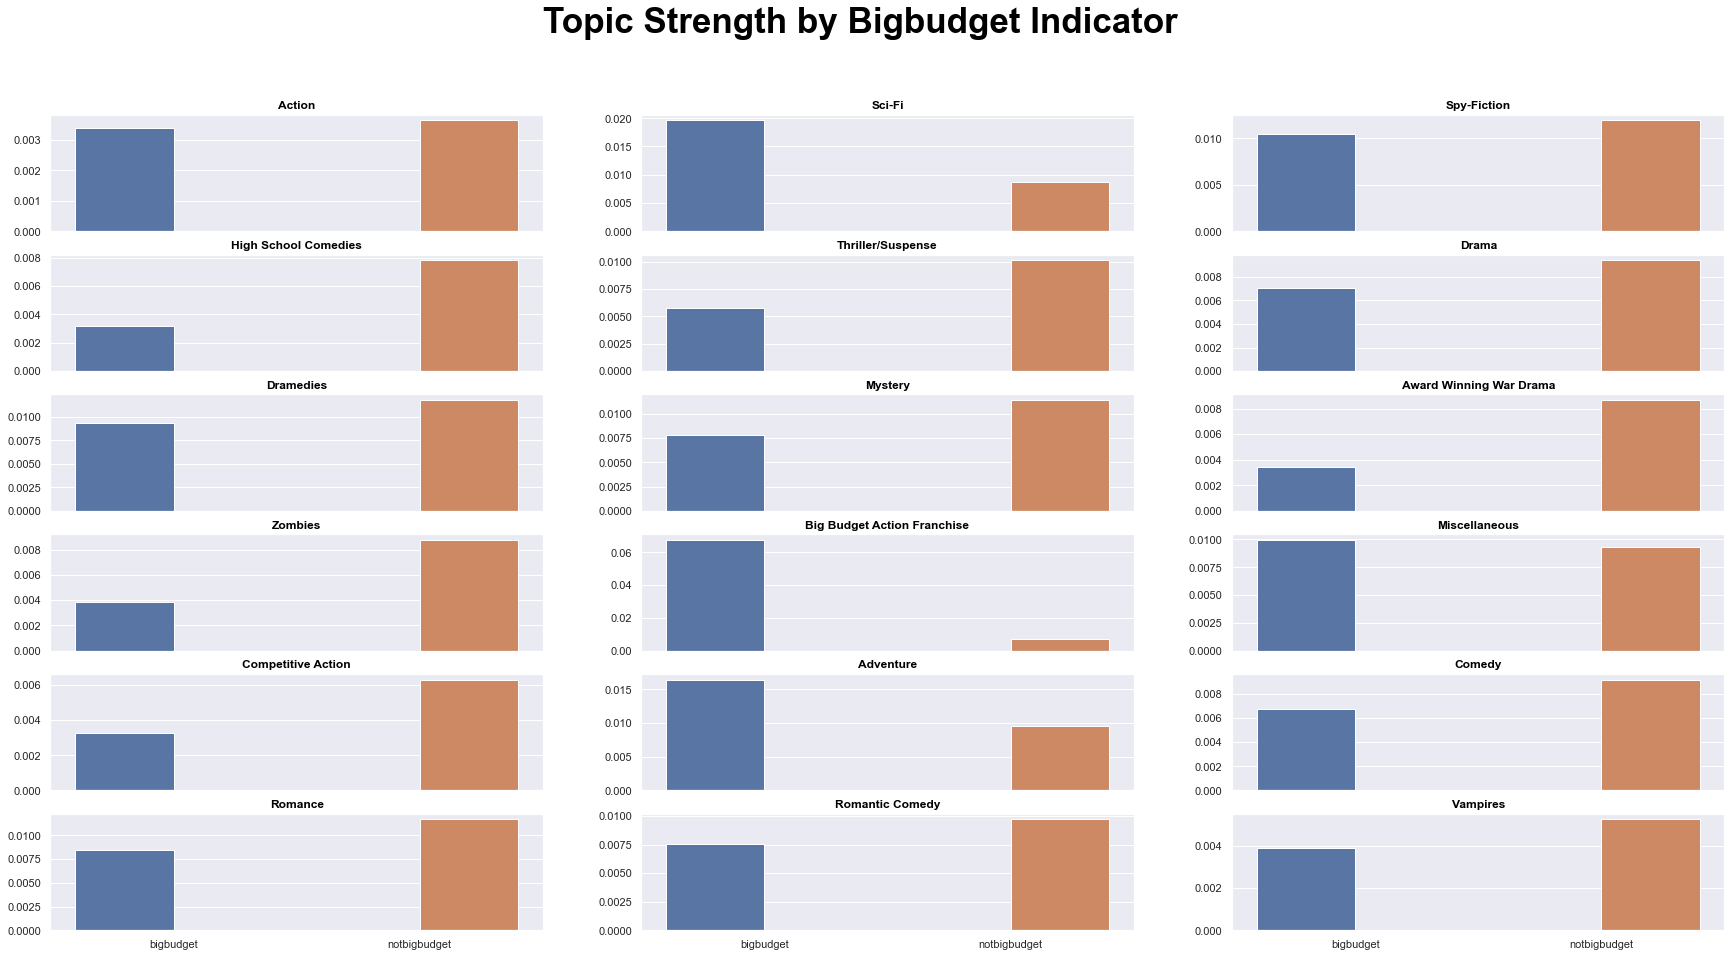

In [1512]:
fig, axes = plt.subplots(6, 3, sharex=True, figsize=(30,15))
fig.suptitle('Topic Strength by Bigbudget Indicator',fontsize=35,fontweight='bold',color='black')
sns.set_style('darkgrid')

for j in range(6):
    for i in range(3):
        sns.barplot(ax=axes[j][i],x='bigbudget', y=topic_columns[j*3 + i], 
                    hue="bigbudget", data=doc_topic_nmf_df_EDA_bb)
        axes[j][i].set(xlabel=None,ylabel=None)
        axes[j][i].set_title(topic_columns[j*3 + i],fontweight='bold',color='black')
        axes[j][i].legend([],[], frameon=False)

In [1457]:
doc_topic_nmf_df_EDA_pop = doc_topic_nmf_df_EDA.groupby('popularmovie')[topic_columns].mean()
doc_topic_nmf_df_EDA_pop = doc_topic_nmf_df_EDA_pop.reset_index()
doc_topic_nmf_df_EDA_pop

,popularmovie,Action,Sci-Fi,Spy-Fiction,High School Comedies,Thriller/Suspense,Drama,Dramedies,Mystery,Award Winning War Drama,...,Vampires,index,id,budget,revenue,vote_average,vote_count,year,budget_2021,decade
0,notpopularmovie,0.003611,0.009195,0.012058,0.007769,0.010176,0.009399,0.011690,0.011379,0.008134,...,0.005271,10214.751786,127188.120357,4.459347e+07,1.384718e+08,6.701286,3010.008571,2005.325714,6.805402e+07,2000.596429
1,popularmovie,0.003948,0.011024,0.008289,0.004309,0.005258,0.007124,0.011535,0.008882,0.013035,...,0.003739,9556.462500,105558.200000,1.199397e+08,6.922086e+08,7.620625,15236.493750,2008.093750,1.665452e+08,2003.375000


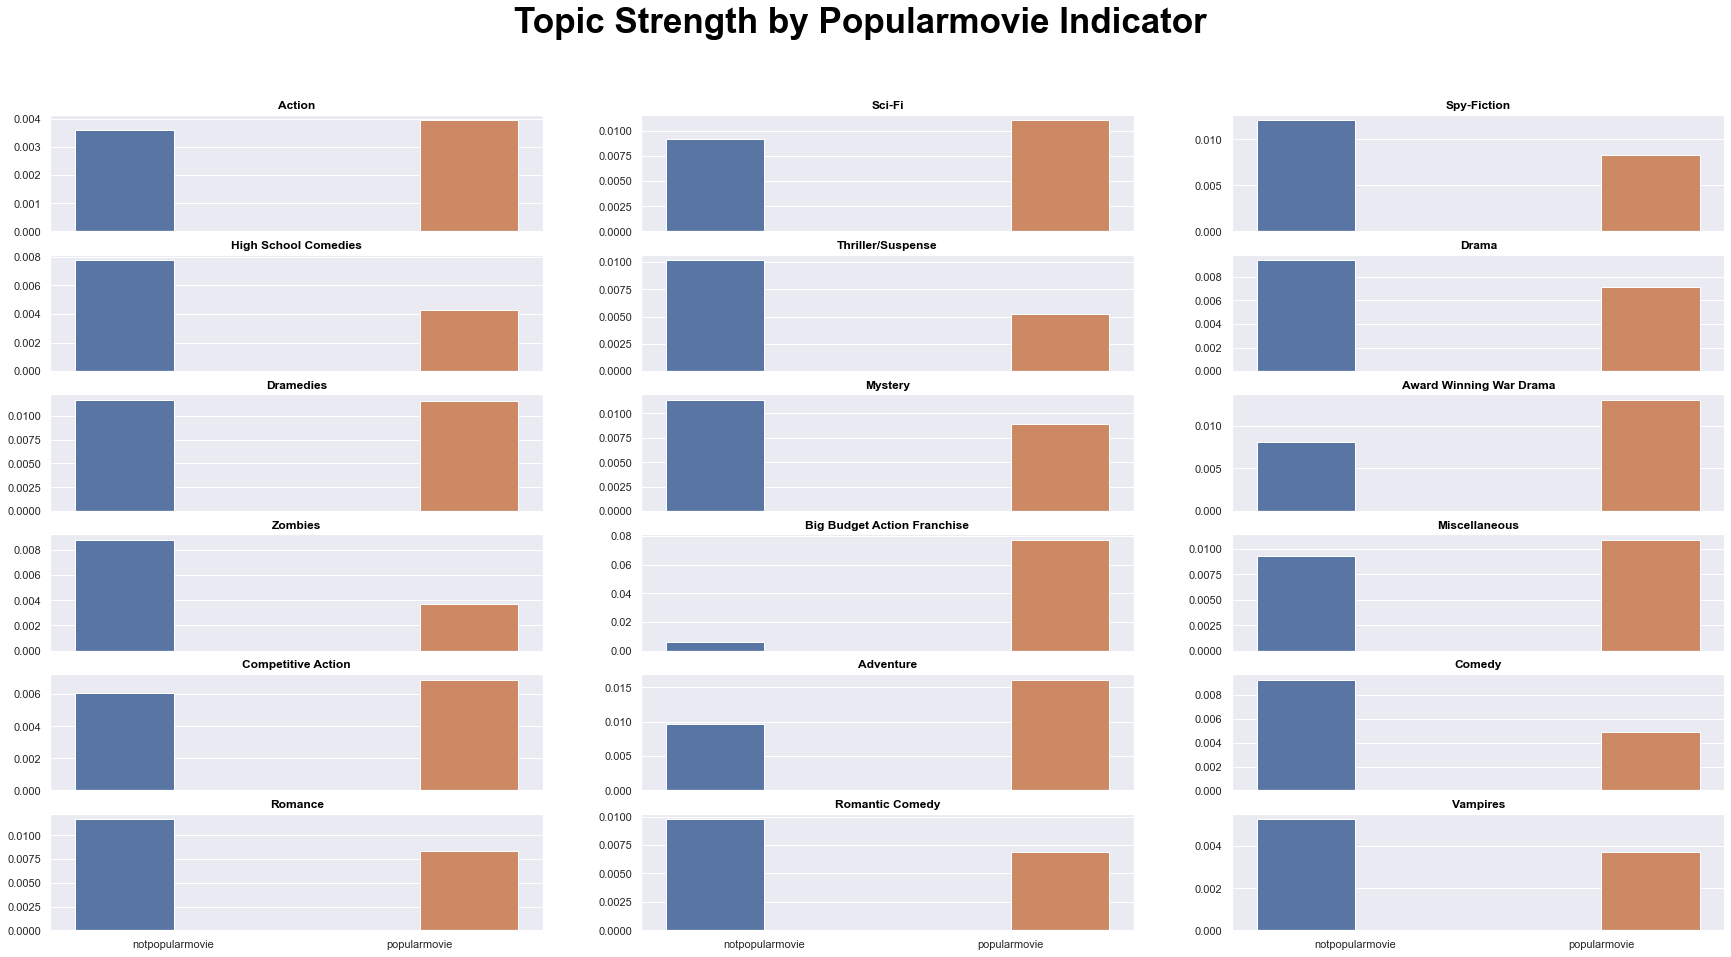

In [1514]:
fig, axes = plt.subplots(6, 3, sharex=True, figsize=(30,15))
fig.suptitle('Topic Strength by Popularmovie Indicator',fontsize=35,fontweight='bold',color='black')
sns.set_style('darkgrid')

for j in range(6):
    for i in range(3):
        sns.barplot(ax=axes[j][i],x='popularmovie', y=topic_columns[j*3 + i], 
                    hue="popularmovie", data=doc_topic_nmf_df_EDA_pop)
        axes[j][i].set(xlabel=None,ylabel=None)
        axes[j][i].set_title(topic_columns[j*3 + i],fontweight='bold',color='black')
        axes[j][i].legend([],[], frameon=False)

In [1459]:
doc_topic_nmf_df_EDA_rate = doc_topic_nmf_df_EDA.groupby('highlyrated')[topic_columns].mean()
doc_topic_nmf_df_EDA_rate = doc_topic_nmf_df_EDA_rate.reset_index()
doc_topic_nmf_df_EDA_rate

,highlyrated,Action,Sci-Fi,Spy-Fiction,High School Comedies,Thriller/Suspense,Drama,Dramedies,Mystery,Award Winning War Drama,...,Vampires,index,id,budget,revenue,vote_average,vote_count,year,budget_2021,decade
0,highlyrated,0.006596,0.007559,0.007464,0.004685,0.008837,0.011840,0.015422,0.009514,0.025323,...,0.003237,8597.873418,140840.981013,3.832185e+07,2.219913e+08,8.194304,8293.075949,1993.632911,6.060369e+07,1989.177215
1,nothighlyrated,0.003461,0.009392,0.012102,0.007745,0.009971,0.009131,0.011471,0.011341,0.007445,...,0.005298,10268.335118,125183.145610,4.924954e+07,1.653818e+08,6.669593,3410.263026,2006.143112,7.409818e+07,2001.399001


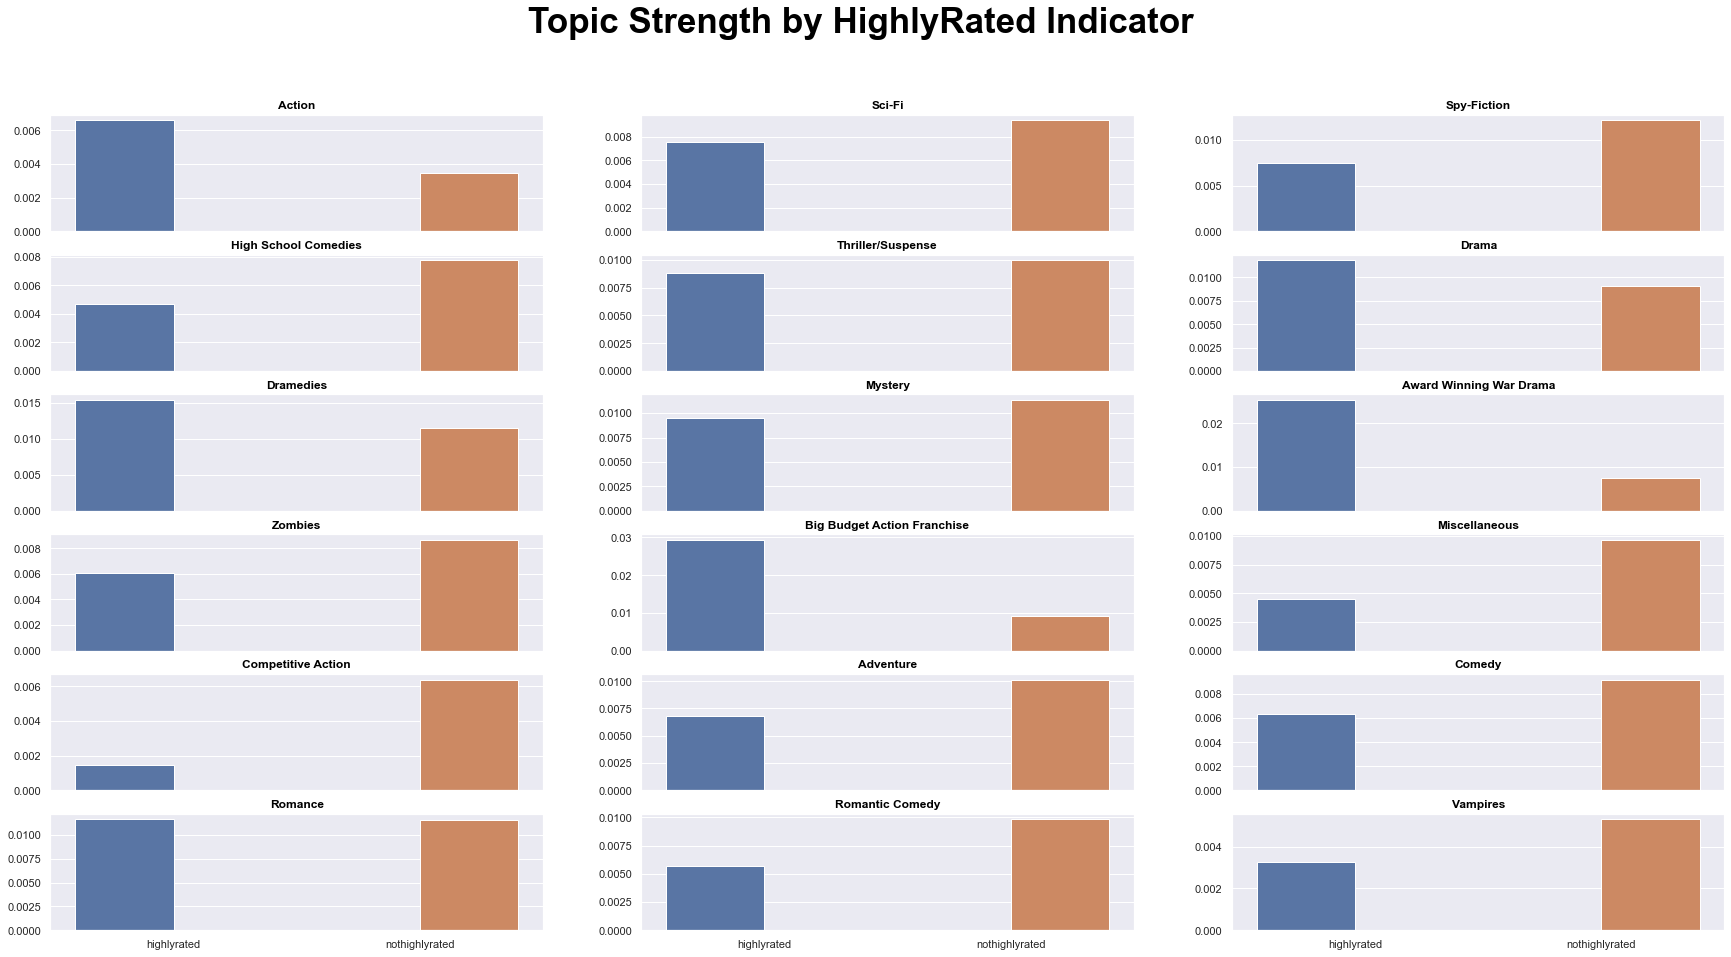

In [1516]:
fig, axes = plt.subplots(6, 3, sharex=True, figsize=(30,15))
fig.suptitle('Topic Strength by HighlyRated Indicator',fontsize=35,fontweight='bold',color='black')
sns.set_style('darkgrid')

for j in range(6):
    for i in range(3):
        sns.barplot(ax=axes[j][i],x='highlyrated', y=topic_columns[j*3 + i], 
                    hue="highlyrated", data=doc_topic_nmf_df_EDA_rate)
        axes[j][i].set(xlabel=None,ylabel=None)
        axes[j][i].set_title(topic_columns[j*3 + i],fontweight='bold',color='black')
        axes[j][i].legend([],[], frameon=False)

In [1461]:
doc_topic_nmf_df_EDA_old = doc_topic_nmf_df_EDA.groupby('oldfilm')[topic_columns].mean()
doc_topic_nmf_df_EDA_old = doc_topic_nmf_df_EDA_old.reset_index()
doc_topic_nmf_df_EDA_old

,oldfilm,Action,Sci-Fi,Spy-Fiction,High School Comedies,Thriller/Suspense,Drama,Dramedies,Mystery,Award Winning War Drama,...,Vampires,index,id,budget,revenue,vote_average,vote_count,year,budget_2021,decade
0,notoldfilm,0.003624,0.009360,0.011880,0.007634,0.009974,0.009319,0.011648,0.011172,0.008391,...,0.005220,10250.358189,126987.326524,4.903647e+07,1.693190e+08,6.742629,3679.491999,2005.996936,7.382139e+07,2001.256384
1,oldfilm,0.004273,0.000918,0.008629,0.000838,0.001752,0.003747,0.016005,0.020364,0.009435,...,0.001146,1088.565217,2359.608696,1.388670e+06,5.150281e+07,7.817391,2573.695652,1938.869565,1.674227e+07,1935.652174


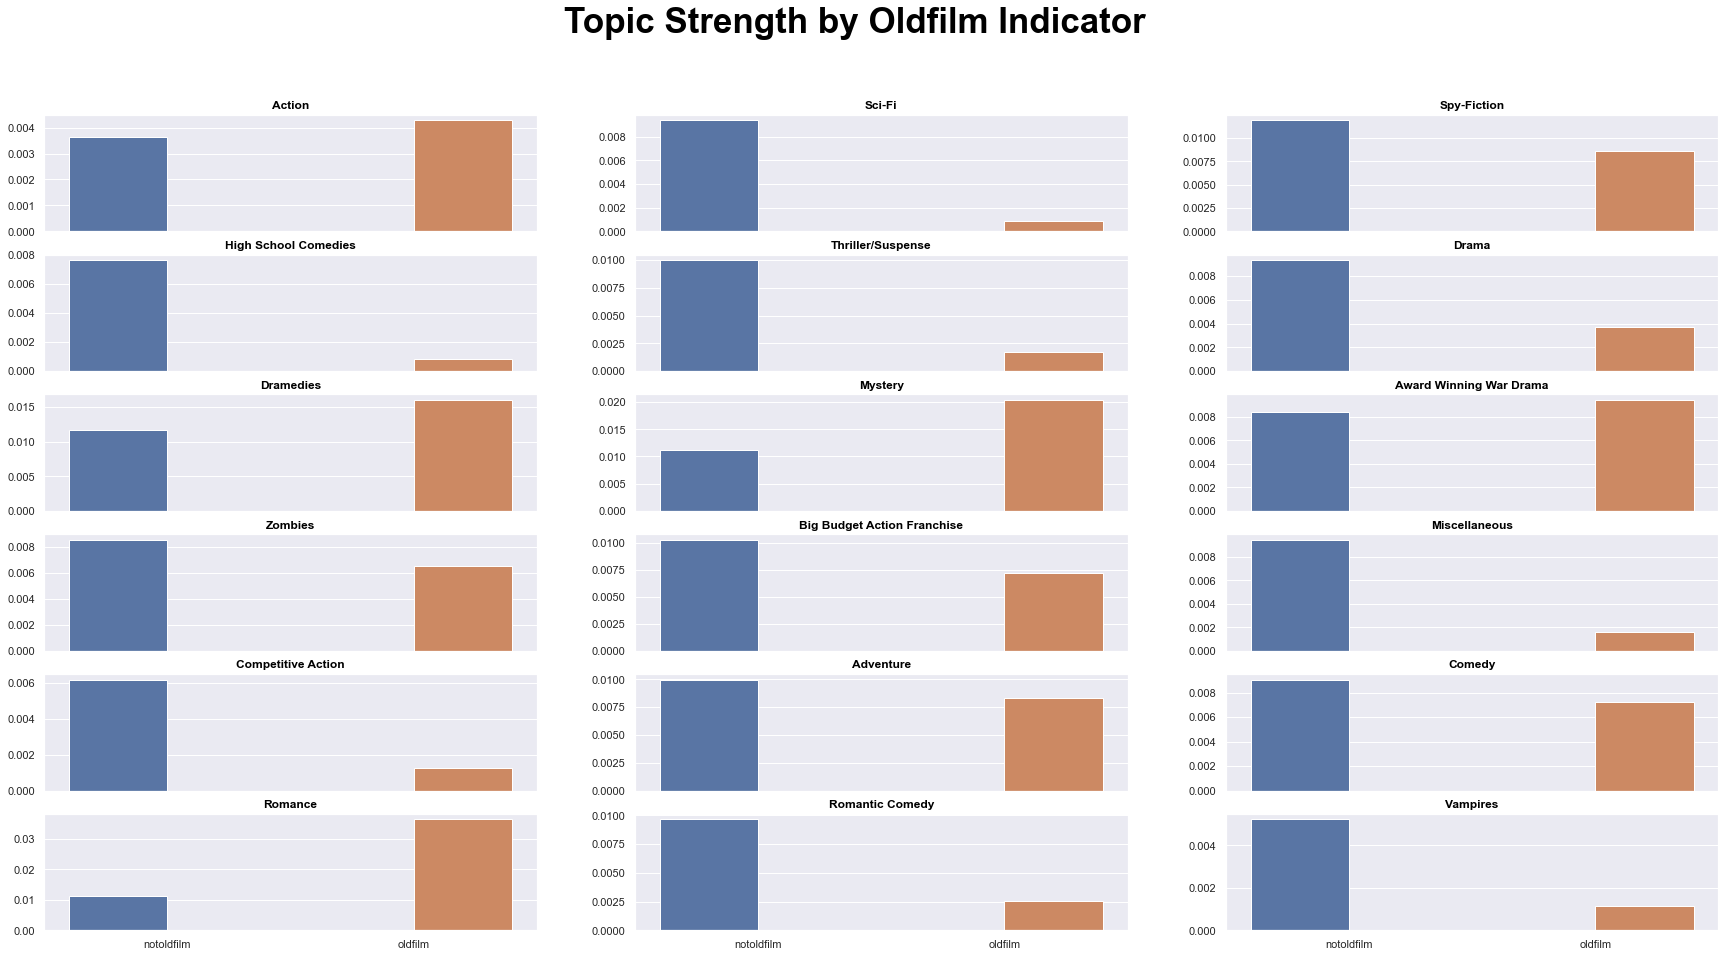

In [1517]:
fig, axes = plt.subplots(6, 3, sharex=True, figsize=(30,15))
fig.suptitle('Topic Strength by Oldfilm Indicator',fontsize=35,fontweight='bold',color='black')
sns.set_style('darkgrid')

for j in range(6):
    for i in range(3):
        sns.barplot(ax=axes[j][i],x='oldfilm', y=topic_columns[j*3 + i], 
                    hue="oldfilm", data=doc_topic_nmf_df_EDA_old)
        axes[j][i].set(xlabel=None,ylabel=None)
        axes[j][i].set_title(topic_columns[j*3 + i],fontweight='bold',color='black')
        axes[j][i].legend([],[], frameon=False)

In [1464]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, perplexity = 40, 
                  random_state=7, angle=.99)

# 18-D -> 2-D
tsne_nmf = tsne_model.fit_transform(doc_topic_nmf_df)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2960 samples in 0.000s...
[t-SNE] Computed neighbors for 2960 samples in 0.141s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2960
[t-SNE] Computed conditional probabilities for sample 2000 / 2960
[t-SNE] Computed conditional probabilities for sample 2960 / 2960
[t-SNE] Mean sigma: 0.019368
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.373924
[t-SNE] KL divergence after 1000 iterations: 1.088135


In [1469]:
top_lst = []
for i in range(0, 2960):
    str1 = doc_topic_nmf_df_describe.iloc[i,:].idxmax()
    #top_lst.append(int(re.sub(r'[a-zA-Z_]','',str1)))
    top_lst.append(str1)

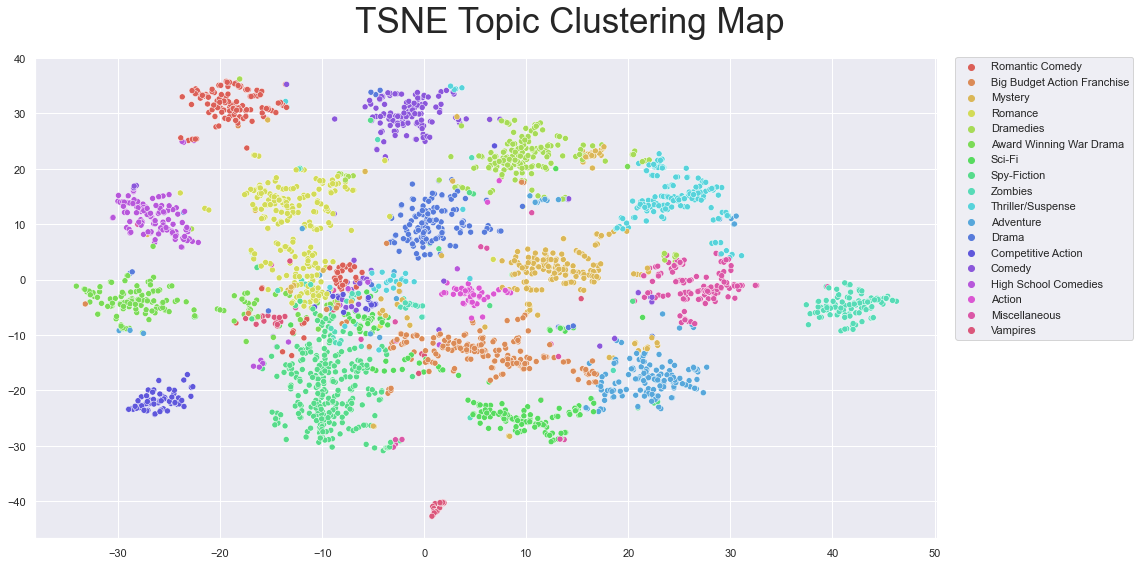

In [1527]:
#Topic Cluster Visualization
x_tsne = tsne_nmf[:,0]
y_tsne = tsne_nmf[:,1]

plt.figure(figsize=(16,8))
sns.scatterplot(
    x=x_tsne, y=y_tsne,
    hue=top_lst,
    palette=sns.color_palette("hls", 18),
    data=doc_topic_nmf_df,
    legend="full",
    alpha=1
)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.suptitle('TSNE Topic Clustering Map', fontsize=35)
plt.tight_layout()
plt.savefig('TSNECluster.png')

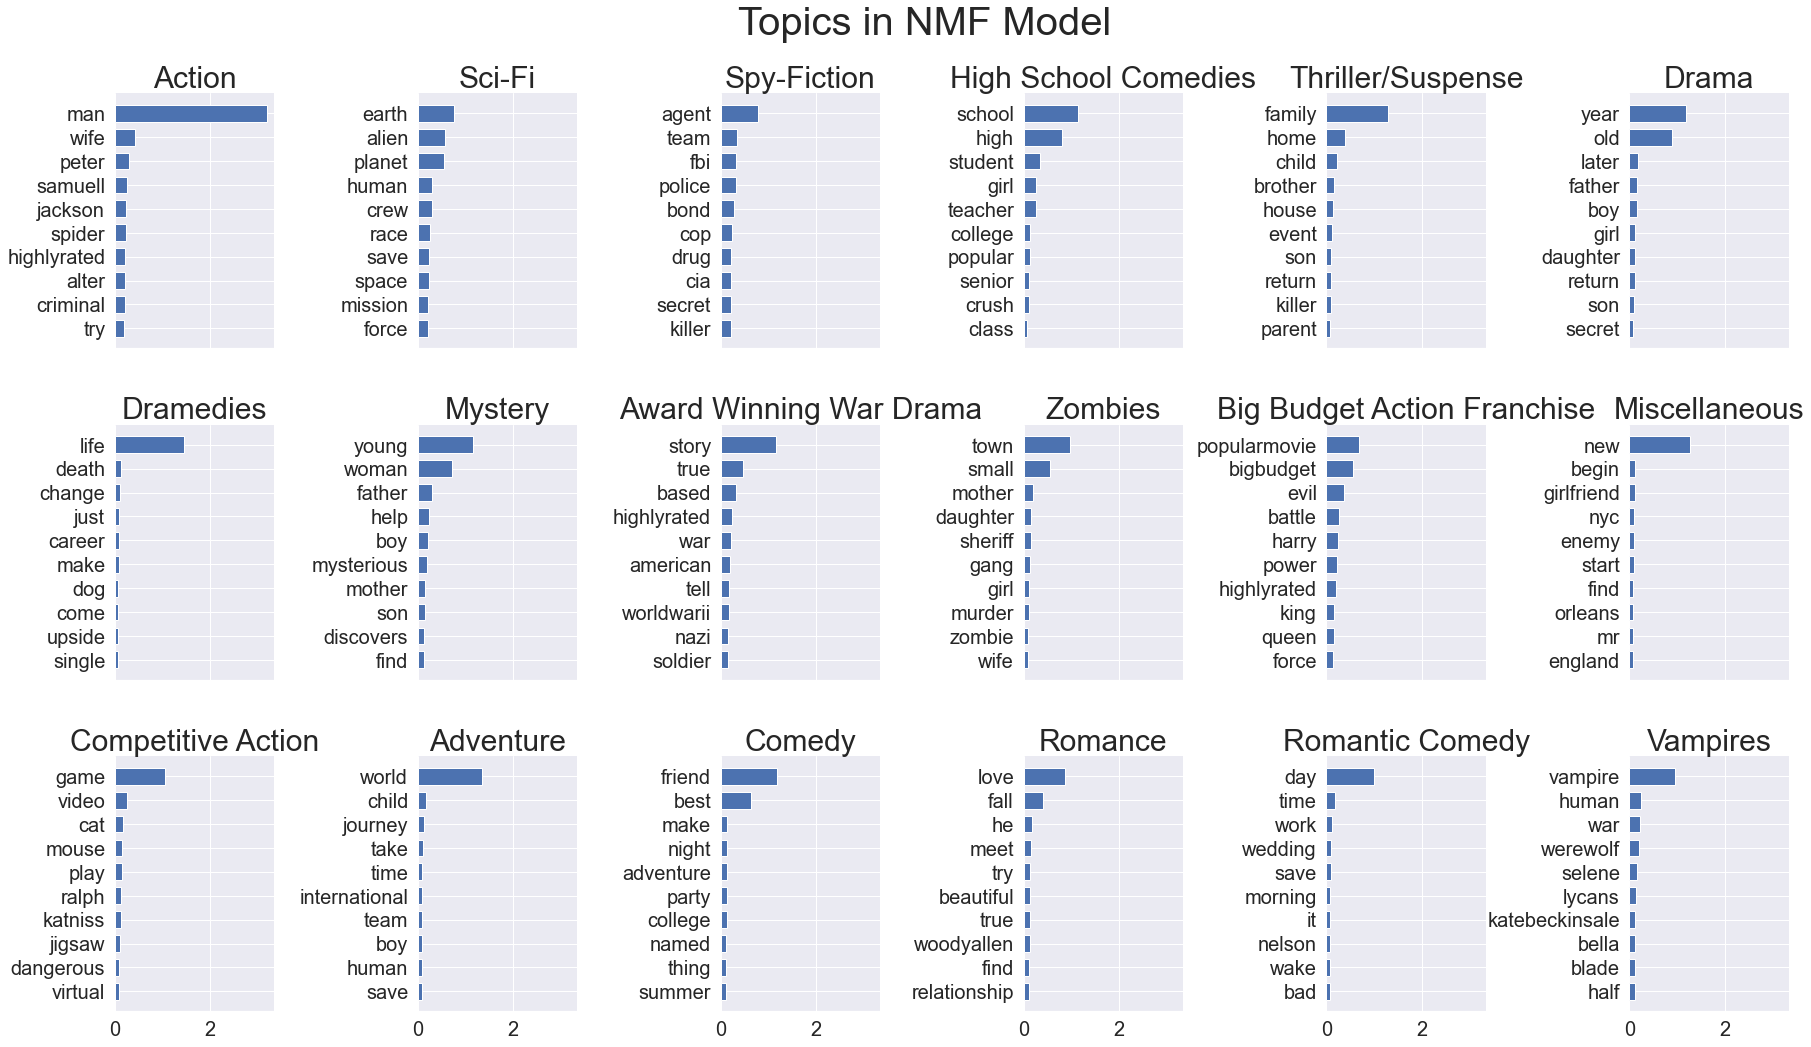

In [1533]:
def plot_top_words(model, feature_names, n_words, title, rows=3, cols=6):

    fig, axes = plt.subplots(3, 6, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    sns.set_style('darkgrid')

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        
        ax.set_title(col_rename['Topic_'+str(topic_idx)],
                 fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
    
    fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
plot_top_words(nmf,tfidf.get_feature_names(),10,'Topics in NMF Model')